# Importing HDF5-formatted particle data

Read/write access to HDF5 files is handled by the Python package `h5py`:

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

First, we create a file object in read-only mode (using `'r'` as the second argument). The output in this case comes from running a simulation using `examples/hdf5_output.yml` as the input configuration.

In [2]:
file = h5py.File('particles.h5', 'r')

Files (and groups) behave like Python dictionaries, in that they are navigated using named keys. At top level, `ptarmigan`'s HDF5 output contains three groups:

In [3]:
list(file.keys())

['build', 'config', 'final-state']

`build` contains data necessary to reconstruct the executable used to produce the current set of output. `config` contains the data necessary to reconstruct the specific run, i.e. the input parameters for the collision. Stepping down one level, we see that `config` contains several groups and datasets.

In [4]:
print(list(file['config'].keys()))
print(file['config/laser'])
print(file['config/mpi-tasks'])

['beam', 'control', 'input-file', 'laser', 'mpi-tasks', 'output']
<HDF5 group "/config/laser" (7 members)>
<HDF5 dataset "mpi-tasks": shape (), type "<i4">


`beam`, `control`, `laser` and `output` are groups containing the parsed values for the input configuration, whereas `input-file` and `mpi-tasks` are datasets. To import a dataset's contents, we use numpy-style indexing. For scalar data, an empty tuple suffices.

In [5]:
print(file['config/input-file'][()])

---
control:
  dt_multiplier: 0.1

laser:
  a0: 1.0
  wavelength: 0.8 * micro
  waist: 3.0 * micro
  fwhm_duration: 30.0 * femto

beam:
  ne: 100000
  gamma: 10.0 * GeV / (m * c^2)
  radius: [1.0 * micro, normally_distributed]
  length: 2.0 * micro

output:
  dump_all_particles: hdf5
  coordinate_system: beam
  electron: [energy]
  photon: [energy]




As such, we see that the HDF5 file stores a copy of the input configuration, to enable the data to be regenerated more easily. `'config/laser'` contains numerical values associated with the `laser` block in the input file:

In [6]:
for key in list(file['config/laser'].keys()):
    val = file['config/laser'][key][()]
    print('{:<15} => {}'.format(key, val))

a0              => 1.0
chirp_b         => 0.0
focusing        => True
fwhm_duration   => 3.0000000000000005e-14
polarization    => 1
waist           => 3e-06
wavelength      => 8e-07


While the meaning of most of these is clear, the polarization of `1` is less so. In order to get more information about a particular dataset, we can query the metadata and attributes associated with it.

In [7]:
pol = file['config/laser/polarization']
print(pol)
print(pol[()])
print(pol.dtype.metadata)

<HDF5 dataset "polarization": shape (), type "|u1">
1
{'enum': {'Linear': 0, 'Circular': 1}}


We see that `polarization` is a C-style enum, with two variants corresponding to linear and circular polarization.

The final top-level group, final-state, contains data about the particles at the end of the simulation.

In [8]:
list(file['final-state/photon'])

['a0_at_creation', 'momentum', 'position', 'weight', 'xi']

(`a0-at-creation` and `xi` are, in fact, the same dataset. The latter is provided as an alias, but both point to the same underlying array.) Importing `'final-state/photon/momentum`' and taking its value yields a numpy array.

In [9]:
p = file['final-state/photon/momentum'][()]

For example, extracting the 0th component of every four-momentum gives us an array of the photon energies.

In [10]:
energies = p[:,0]
energies

array([1117.53358022,   37.93597395, 1580.3938257 , ...,  777.11028204,
        388.40190672,  613.6486069 ])

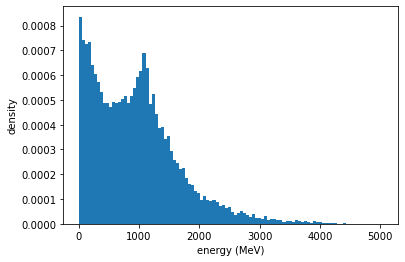

In [11]:
plt.hist(energies, density=True, bins=100)
plt.ylabel('density')
plt.xlabel('energy (MeV)')
plt.show()